# Dimensionality Reduction

This notebook investigates possible ways to preprocess the wine properties (input variables). Preprocessing helps further our understanding of the data and can improve model performance by handling highly correlated input variables.

We explore a few different methods:
* **Principal Component Analysis (PCA)**: A method to intelligently combine the input variables into a smaller subset of varaibles that capture most of the information in the dataset. Phrased more technically, it projects the raw data to a linear subspace that maximizes the variance explained by each subsequent projection. This method is especially effective in summarizing linear dependencies between input variables. This is an *unsupervised* method meaning it does not take into account the target variable (wine quality) and instead leverages dominant patterns in the input data.
* **Linear Discriminant Analysis (LDA)**: A linear projection method that maximizes the separation between target variable (wine quality) classes. The use of the target variable helps learn an input representation that is most relevant to the business questions of understanding wine quality.

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

sns.set_palette('colorblind')
sns.set_context('notebook')

In [80]:
df = pd.read_csv('./winequality-red.csv')

In [81]:
feat_data = df.iloc[:, :-1]
targ_data = df.iloc[:, -1]

# Principal Component Analysis (PCA)

PCA is a common unsupervised method to compress information in the raw data into a smaller number of variables. This can aid model performance and further help us understand the dataset.


In [82]:
# standardize the data - important for PCA
scaler = StandardScaler()
standardized_data = scaler.fit_transform(feat_data)

After standardization, we extract the **eigenvectors**, a fancy math term for the resulting compressed dataset representations, and **eigenvalues**, which represent the proportion of variance that each eigenvector accounts for. If all variables are perfectly linearly correlated with each other, there would be only 1 non-zero eigenvector with an eigenvalue of 1 (because it would represent 100% of the variance in the dataset).

In [83]:
# get PCA decomposition
pca = PCA()
eigenvectors = pca.fit_transform(standardized_data)
# fetch both the original and standardized eigenvalues
eigenvalues_stand = pca.explained_variance_ratio_

After calculating the PCA components, we plot the first two (most important) against each other along with quality rating to check for emerging clusters or patterns in the transformed space.

No meaningful clusters have emerged, but the coloring pattern (by wine quality) suggests that the second principal component (y-axis) may be helpful to separate high vs low quality wines. This is visible in how the lower data points along the y-axis are darker than the data points higher along the axis.

Text(0, 0.5, 'Second Principal Component')

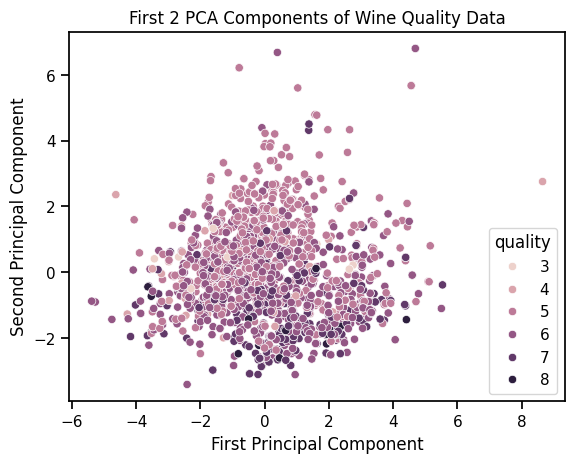

In [84]:
# plot first two components (always ranked by descending variance explained/importance)
ax = sns.scatterplot(x=eigenvectors[:, 0], y=eigenvectors[:, 1], hue=df['quality'])
plt.title('First 2 PCA Components of Wine Quality Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

The variance explained by component helps us understand the level of correlation between the input variables (e.g., how well they can be compressed into fewer variables). 

The first two components represent about half the variance in the dataset, which is substantial. These two components represent the primary ways in which the wines vary in the variable space.

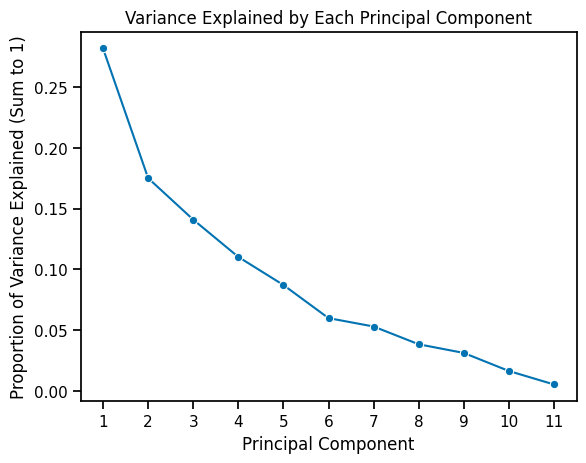

In [85]:
ax = sns.lineplot(x=range(1, len(eigenvalues_stand) + 1), y=eigenvalues_stand, marker='o')
# change x-axis to show by increments of 1
ax.set_xticks(range(1, len(eigenvalues_stand) + 1))
plt.title('Variance Explained by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained (Sum to 1)');

In [86]:
sum(eigenvalues_stand[:2])  # first two components explain about half of the variance

np.float64(0.45682201184294036)

Finally, we take a look at what each PCA component represents in terms of the original input variables.

In the heatmap and vector maps below, it's clear that the first principal component captures the linear relationships between fixed acidity, citric acid, density, and pH. The second component summarized the correlation between free sulfur dioxide and total sulfur dioxide. Both of these line up with our findings in the Exploratory Data Analysis step.

In [87]:
# check the loadings of each feature on the components
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=feat_data.columns, columns=[f'PC{i+1}' for i in range(len(loadings[0]))])

<Axes: >

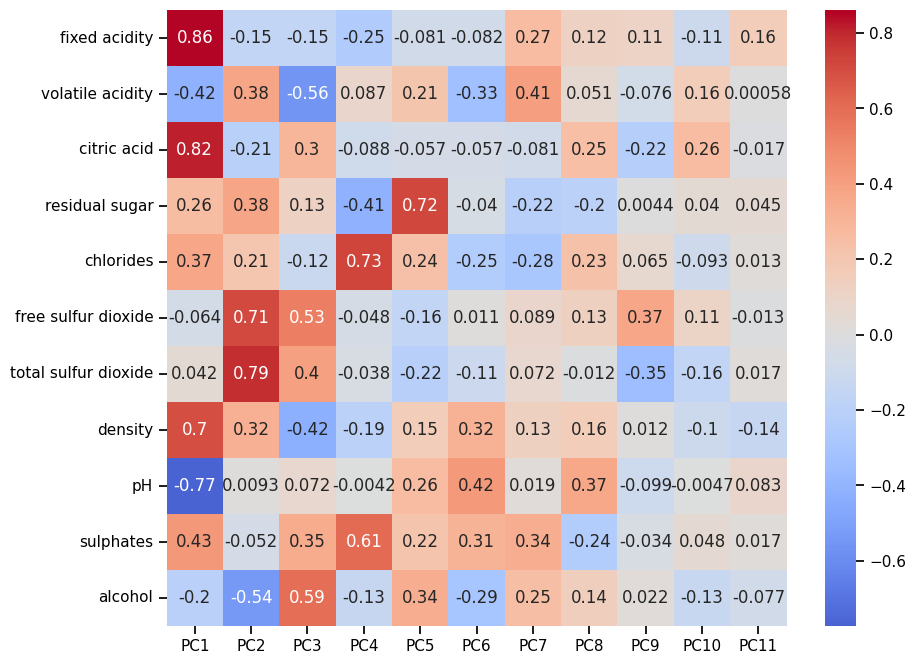

In [88]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0, ax=ax)

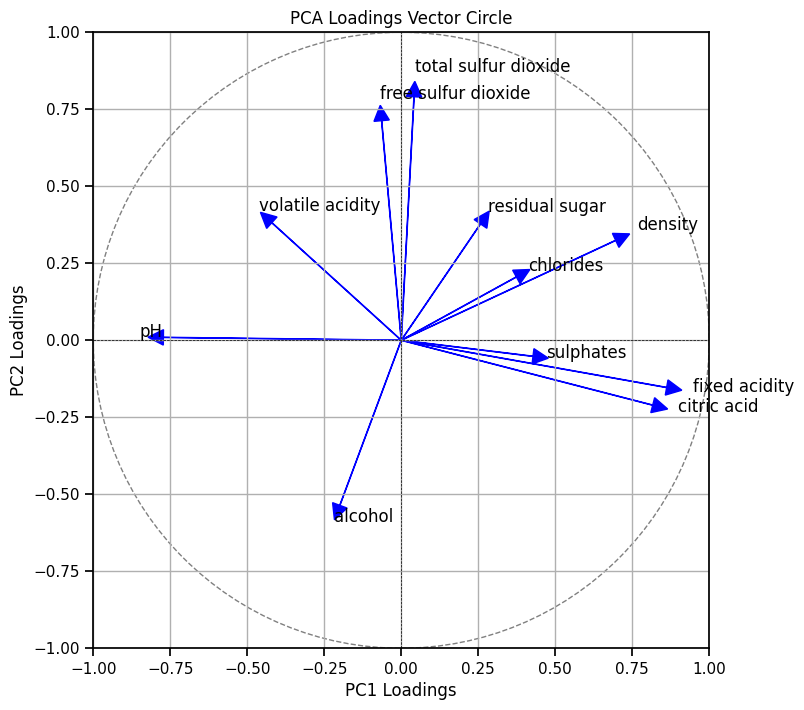

In [89]:

# plot the vector circle of the loadings for the first two components
fig, ax = plt.subplots(figsize=(8, 8))
# plot a unit circle to visualize the loadings
ax.add_patch(plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--'))
for i in range(len(loadings_df)):
    ax.arrow(0, 0, loadings_df.iloc[i, 0], loadings_df.iloc[i, 1], 
             head_width=0.05, head_length=0.05, fc='blue', ec='blue')
    ax.text(loadings_df.iloc[i, 0] * 1.1, loadings_df.iloc[i, 1] * 1.1, 
            loadings_df.index[i], fontsize=12)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_title('PCA Loadings Vector Circle')
plt.xlabel('PC1 Loadings')
plt.ylabel('PC2 Loadings')
plt.grid()
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.gca().set_aspect('equal', adjustable='box')

# Linear Discriminant Analysis

Linear Discriminant Analysis (LDA) is mathematically quite similar to PCA, with a different objective of explaining differences between target classes. Therefore, the compressed representation is more targeted towards our goal of understanding what input variables relate to wine quality.

In [90]:
lda = LDA()
lda.fit(standardized_data, targ_data)
lda_eigenvectors = lda.transform(standardized_data)
lda_eigenvalues = lda.explained_variance_ratio_

As with PCA, we check how significant each learned component is, but in the case of LDA it represents the percent of between-class vs within-class variation. 

The first component represents over 80% of the discrimination power between classes, indicating that most of the differences in wine quality can be captured by this first component.

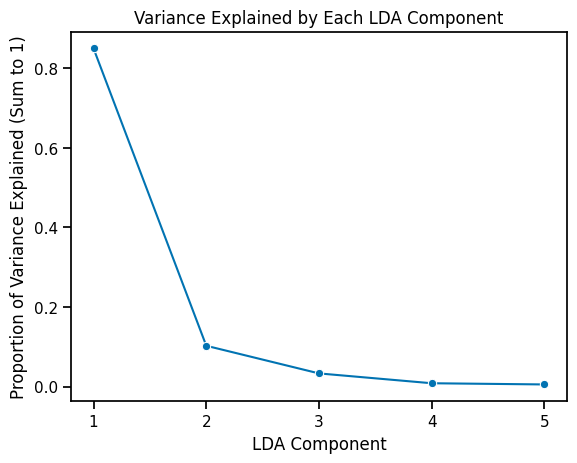

In [94]:
# lineplot of eigenvalues
ax = sns.lineplot(x=range(1, len(lda_eigenvalues) + 1), y=lda_eigenvalues, marker='o')
ax.set_xticks(range(1, len(lda_eigenvalues) + 1))
ax.set_title('Variance Explained by Each LDA Component')
ax.set_xlabel('LDA Component')
ax.set_ylabel('Proportion of Variance Explained (Sum to 1)');

Due to the high class variation explained by the first component, it's quite interesting to dig into what that first component represents in terms of the original variables.

A bar plot of the loadings of the original variables onto the first Linear Discriminant component (LD1) lines up with our Exploratory Data Analysis - a higher alcohol content and lower volatile acidity are indicative of higher quality wines.

Interestingly, while free sulfur dioxide and total sulfur dioxide are correlated, their signed contribution to the LD1 are in opposite directions. 

In [95]:
# get scalings to understand contribution of each feature
scalings = lda.scalings_
scalings_df = pd.DataFrame(scalings, index=feat_data.columns, columns=[f'LD{i+1}' for i in range(scalings.shape[1])])

/var/folders/4f/sh13d18n6xqfgdy91ybht1pc0000gn/T/ipykernel_27373/2149022007.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


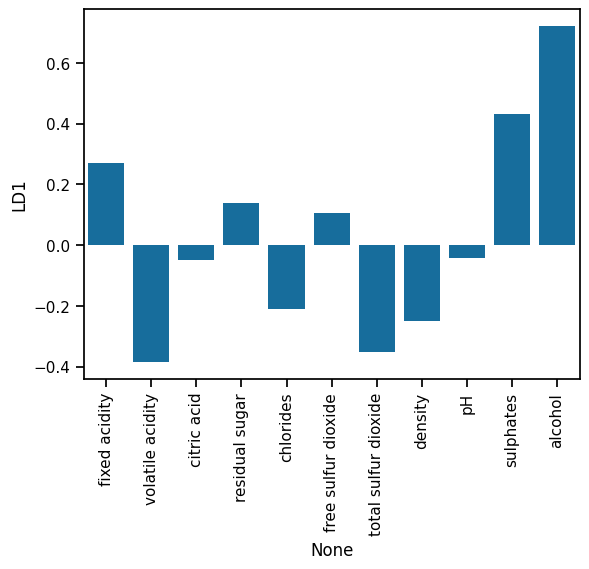

In [96]:
ax = sns.barplot(data=scalings_df, x=scalings_df.index, y='LD1')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Plotting the wine dataset in the first and second linear discriminants show visually how well the first linear discriminant helps pull apart the good (dark-colored) vs bad (light-colored) wines.

Text(0, 0.5, 'Second Linear Discriminant')

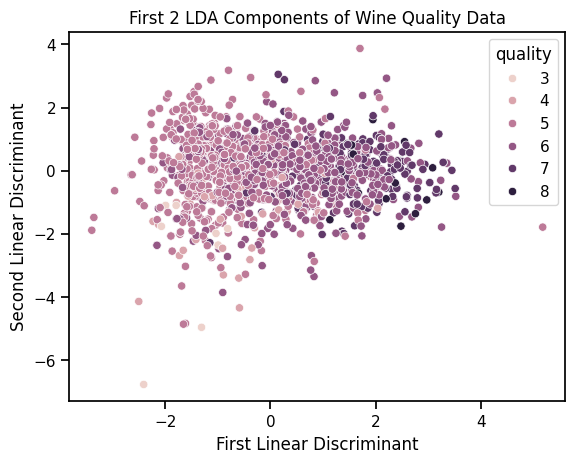

In [97]:
ax = sns.scatterplot(x=lda_eigenvectors[:, 0], y=lda_eigenvectors[:, 1], hue=df['quality'])
ax.set_title('First 2 LDA Components of Wine Quality Data')
ax.set_xlabel('First Linear Discriminant')
ax.set_ylabel('Second Linear Discriminant')

### Removing outliers and repeat LDA

During Exploratory Data Analysis we found a few notable outliers which may skew model results.

In this section we remove those outliers and repeat LDA.

In [103]:
outliers = feat_data[
    (feat_data['alcohol'] > 14)
    | (feat_data['sulphates'] > 1.8)
    | (feat_data['total sulfur dioxide'] > 200)
    | (feat_data['chlorides'] > 0.5)
]

feat_no_outliers = feat_data.drop(outliers.index)
stand_no_outliers = scaler.fit_transform(feat_no_outliers)

In [104]:
lda_no_outliers = LDA()
lda_no_outliers.fit(stand_no_outliers, targ_data.drop(outliers.index))
lda_no_outliers_eigenvectors = lda_no_outliers.transform(stand_no_outliers)
lda_no_outliers_eigenvalues = lda_no_outliers.explained_variance_ratio_

The loadings onto the primary component have not changed significantly - alcohol and sulphates are still primary positive correlates to higher quality and fixed acidity is a primary detractor.

/var/folders/4f/sh13d18n6xqfgdy91ybht1pc0000gn/T/ipykernel_27373/4197262895.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


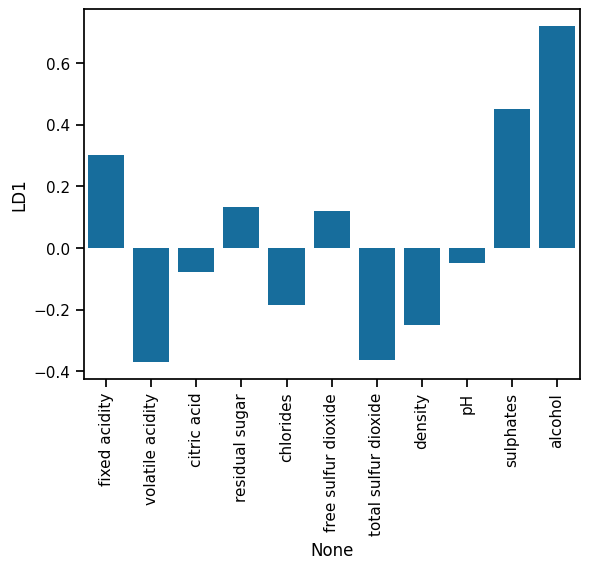

In [105]:
# check how the loadings change without outliers
loading_no_outliers = lda_no_outliers.scalings_
loading_no_outliers_df = pd.DataFrame(loading_no_outliers, index=feat_no_outliers.columns, 
                                       columns=[f'LD{i+1}' for i in range(loading_no_outliers.shape[1])])
ax = sns.barplot(data=loading_no_outliers_df, x=loading_no_outliers_df.index, y='LD1')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

The variance explained by subsequent components has not noticeably changed.

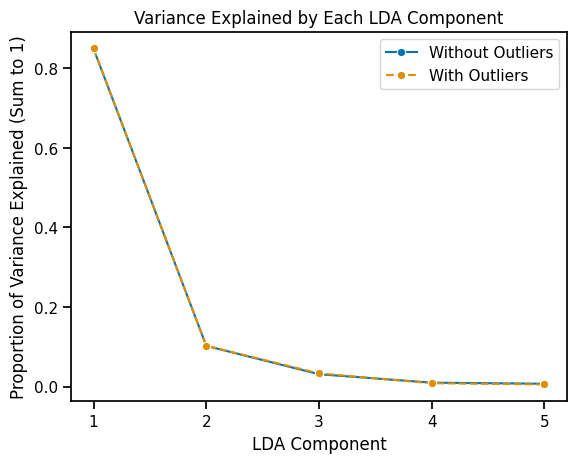

In [108]:
# check the eigenvalue plot without outliers
ax = sns.lineplot(x=range(1, len(lda_no_outliers_eigenvalues) + 1), 
                  y=lda_no_outliers_eigenvalues, marker='o', label='Without Outliers')
# overlay with the original eigenvalues for comparison
sns.lineplot(x=range(1, len(lda_eigenvalues) + 1),
                  y=lda_eigenvalues, marker='o', linestyle='--', label='With Outliers')
plt.legend()
ax.set_xticks(range(1, len(lda_eigenvalues) + 1))
ax.set_title('Variance Explained by Each LDA Component')
ax.set_xlabel('LDA Component')
ax.set_ylabel('Proportion of Variance Explained (Sum to 1)');